This code comprises various implemented methods, each accompanied by its respective code snippet. Within the code, assign the directory path to the variable named main_directory. It's important to note that these sections are self-contained and operate independently of each other. Considering system resources, every section is executed on a separate server instance as an individual Python file.

# Part-1

In [242]:
from transformers import TFBertForMaskedLM, BertTokenizer, BertConfig
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import json

In [243]:
main_directory=""# main directory file name

In [244]:
data=pd.read_csv("C:/Users/AKHIL RAJ R/Desktop/bert_mlm/method_1/main_file.tsv",delimiter="\t")
#data=pd.read_csv('/content/gdrive/MyDrive/bert_mlm/main_file.tsv', delimiter="\t")
data=data[['patient_id','event_date','LTC_abbrev','age_at_event','sex']]
data=data.dropna().drop_duplicates()
data['Rank'] = data.groupby('patient_id')['event_date'].rank(ascending=True,method='min')
uniq_patientid=data['patient_id'].unique()

## EDA

Top 10 disease based on its occurance

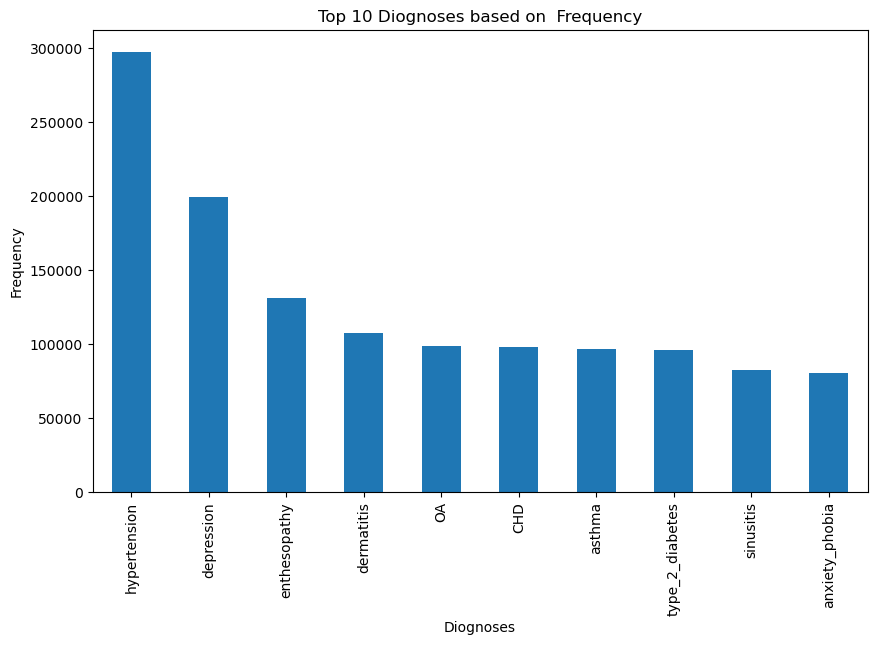

In [245]:
value_counts = data['LTC_abbrev'].value_counts().head(10)  # Select top 10 frequent values

# Create a bar plot of the frequency counts
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Diognoses')
plt.ylabel('Frequency')
plt.title('Top 10 Diognoses based on  Frequency')
plt.show()

#Age Frequency

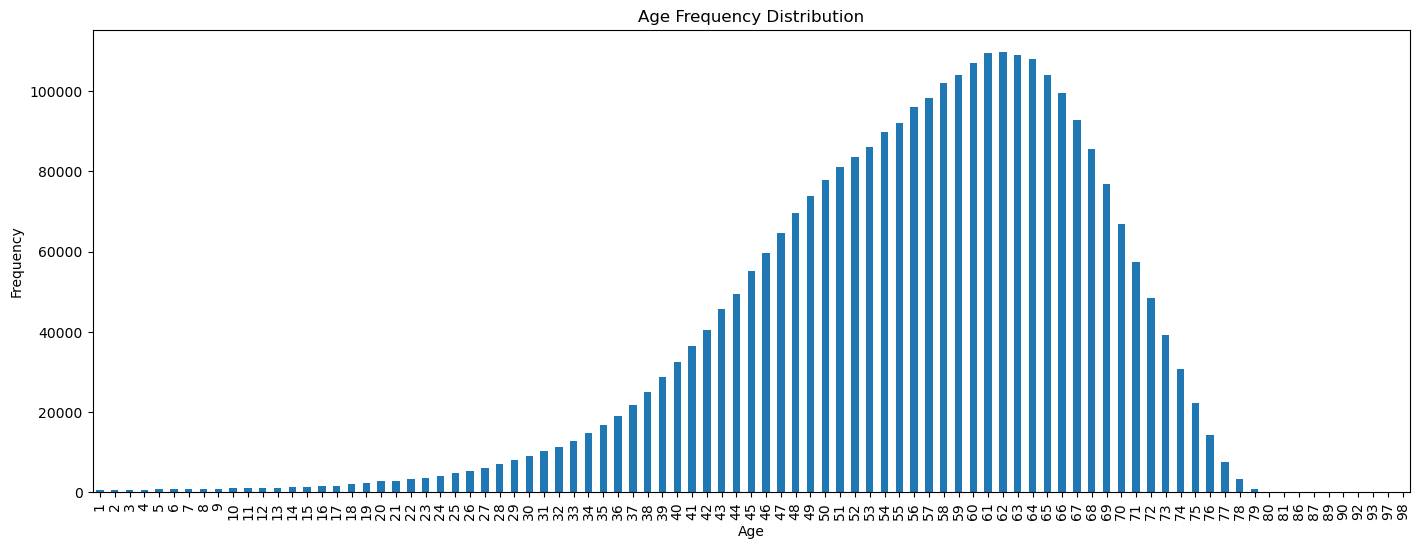

In [4]:
value_counts = data['age_at_event'].value_counts().sort_index()#.head(10)  # Select top 10 frequent values

# Create a bar plot of the frequency counts
plt.figure(figsize=(17, 6))
value_counts.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Frequency Distribution')
plt.show()

Most common disease in males

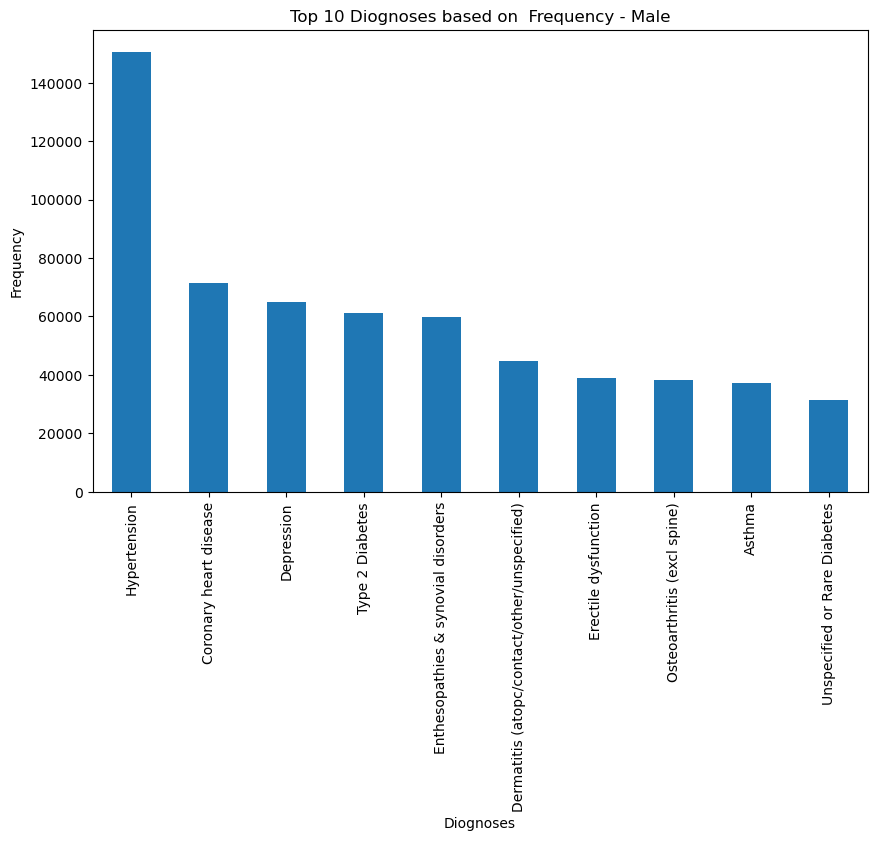

In [17]:

value_counts = data.loc[data['sex'] == 'M', 'LTC'].value_counts().head(10)  # Select top 10 frequent values

# Create a bar plot of the frequency counts
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Diognoses')
plt.ylabel('Frequency')
plt.title('Top 10 Diognoses based on  Frequency - Male')
plt.show()

most common disease in females

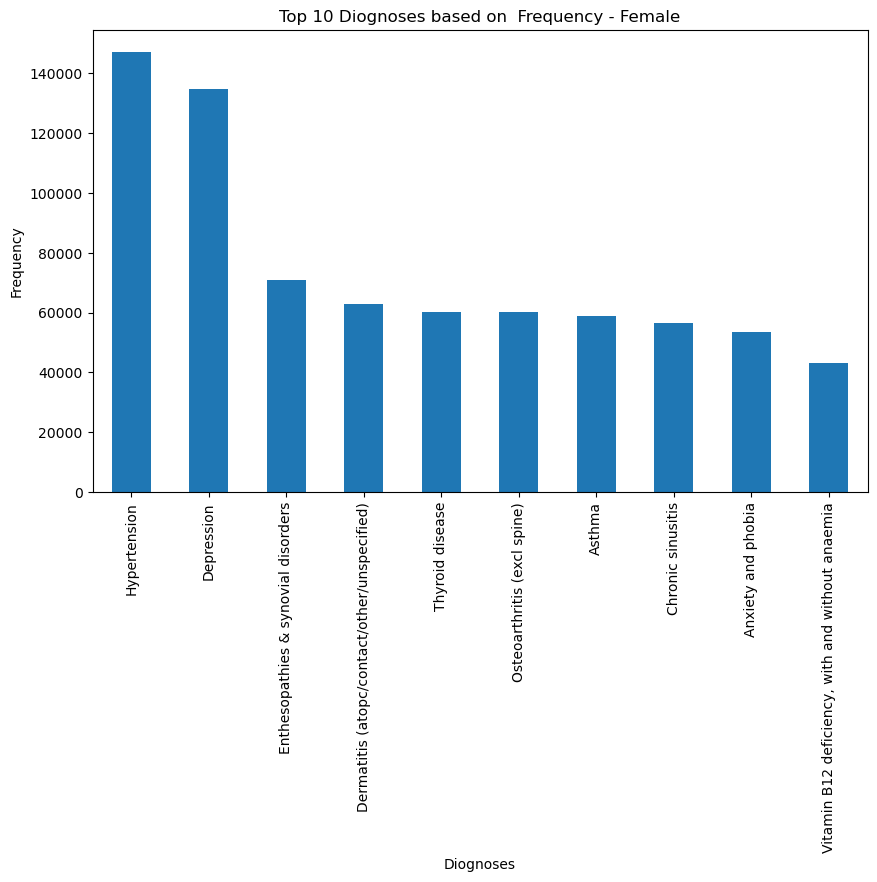

In [19]:

value_counts = data.loc[data['sex'] == 'F', 'LTC'].value_counts().head(10)  # Select top 10 frequent values

# Create a bar plot of the frequency counts
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Diognoses')
plt.ylabel('Frequency')
plt.title('Top 10 Diognoses based on  Frequency - Female')
plt.show()

In [ ]:
len(data.LTC_abbrev)

In [ ]:
diff_A_B = set(data.loc[data['sex'] == 'F', 'LTC_abbrev']) - set(data.loc[data['sex'] == 'M', 'LTC_abbrev'])
print("A - B:", diff_A_B)

In [ ]:
diff_A_B =  set(data.loc[data['sex'] == 'M', 'LTC_abbrev'])-set(data.loc[data['sex'] == 'F', 'LTC_abbrev'])
print("A - B:", diff_A_B)

In [ ]:
intersection_A_B = set(data.loc[data['sex'] == 'M', 'LTC_abbrev']) & set(data.loc[data['sex'] == 'F', 'LTC_abbrev'])
print("A ∩ B:", intersection_A_B)

In [ ]:
len(intersection_A_B)

## Pre-processing

In [33]:
# making the data suitable for bert and craeting the vocabulary file
b=[]
vocab=[]
for u in uniq_patientid:
  temp=data[data['patient_id']==u].copy()
  a=''
  for i in range(0,len(temp)):
   if len(temp)>7:
    if temp.iloc[i,2] not in vocab:
     vocab.append(temp.iloc[i,2])
    if len(a)==0:
     a='[CLS] '+temp.iloc[i,2]
    elif temp.iloc[i,1]!= temp.iloc[i-1,1]:
     a=a+' [SEP] '+temp.iloc[i,2]
    else :
      a=a+' '+ temp.iloc[i,2]
  if len(a)>0:
   b.append(a + ' [SEP]')

In [ ]:
# Save the custom vocabulary as vocab.txt
# Add special tokens if desired
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]','[MASK]']
custom_vocab = special_tokens + vocab
with open(os.path.join(main_directory,'vocab.txt'), 'w', encoding='utf-8') as f:
    for i,term in enumerate(custom_vocab):
      if i==len(custom_vocab)-1:
        f.write(term)
      else:
       f.write(term + '\n')


In [113]:
# Path to your custom vocabulary file (vocab.txt)
vocab_file = os.path.join(main_directory,"vocab.txt")

# Create a new tokenizer instance
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)
def my_tokenization(text):
    # Implement your custom tokenization logic here
    # Return a list of tokens
    # For example, split the text by spaces
    tokens = text.split()

    return tokens

# Set the tokenizer's tokenization function to your custom function
tokenizer.tokenize = my_tokenization

In [114]:
def preprocess(combined_sentence):
 tokens = tokenizer.tokenize(combined_sentence)
 segment_ids = []
 current_segment_id = 0

 for token in tokens:
    segment_ids.append(current_segment_id)
    if token == '[SEP]':
      if current_segment_id==1:
        current_segment_id=0
      else:
        current_segment_id=1
        #current_segment_id += 1
 token_ids = tokenizer.convert_tokens_to_ids(tokens)
 attention_mask = [1] * len(token_ids)
 return tokens,segment_ids,token_ids,attention_mask
def preprocess_main(h):
  tokens_array=[]
  segment_ids_array=[]
  token_ids_array=[]
  attention_mask_array=[]
  for st in h:
   v1,v2,v3,v4=preprocess(st)
   tokens_array.append(v1)
   segment_ids_array.append(v2)
   token_ids_array.append(v3)
   attention_mask_array.append(v4)

  max_length =985# max(len(ids) for ids in token_ids_array)
  padded_token_ids = [ids + [0] * (max_length - len(ids)) for ids in token_ids_array]
  padded_segment_ids = [ids + [0] * (max_length - len(ids)) for ids in segment_ids_array]
  attention_mask = [ids+ [0] * (max_length - len(ids)) for ids in attention_mask_array]
  input_ids = tf.convert_to_tensor(padded_token_ids)
  segment_ids = tf.convert_to_tensor(padded_segment_ids)
  attention_mask = tf.convert_to_tensor(attention_mask)
  return input_ids,attention_mask,segment_ids

In [ ]:
tokenid_tensor,attention_mask_tensor,padded_segment_ids_tensor=preprocess_main(b)
label=tokenid_tensor

In [45]:
np.random.seed(10)
inp_ids = []
lbs = []
idx = 0
for inp in tokenid_tensor.numpy():
    actual_tokens = list(set(range(max_length)) -
                         set(np.where((inp == 2) | (inp == 3)
                            | (inp == 0))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens),
                                     size=num_of_token_to_mask,
                                     replace=False).tolist()
    #Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 4
    inp_ids.append(inp)
    idx += 1
inp_ids = tf.convert_to_tensor(inp_ids)
tokenid_tensor = inp_ids

## saving files

In [46]:
np.save(os.path.join(main_directory,"tokenid_tensor.npy"), tokenid_tensor.numpy())
np.save(os.path.join(main_directory,"attention_mask_tensor.npy"), attention_mask_tensor.numpy())
np.save(os.path.join(main_directory,"padded_segment_ids_tensor.npy"), padded_segment_ids_tensor.numpy())
np.save(os.path.join(main_directory,"label.npy"), label.numpy())

## loading data For Training

In [30]:
#74820 is the 80% of the data 
tokenid_tensor=tf.convert_to_tensor(np.load(os.path.join(main_directory,"tokenid_tensor.npy"))[:74820])
attention_mask_tensor=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask_tensor.npy"))[:74820])
padded_segment_ids_tensor=tf.convert_to_tensor(np.load(os.path.join(main_directory,"padded_segment_ids_tensor.npy"))[:74820])
label=tf.convert_to_tensor(np.load(os.path.join(main_directory,"label.npy"))[:74820])

In [32]:
def convert_to_json_serializable(obj):
    if isinstance(obj, dict):
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    else:
        return obj
def convert_from_json_serializable(obj):
    if isinstance(obj, dict):
        return {key: convert_from_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, float):
        return np.float32(obj)
    elif isinstance(obj, int):
        return np.int32(obj)
    else:
        return obj

def load_optimizer_config_from_json(file_path):
    # Load the optimizer configuration from the JSON file
    with open(file_path, 'r') as f:
        optimizer_config_serializable = json.load(f)

    # Convert the optimizer configuration back to original types
    optimizer_config = convert_from_json_serializable(optimizer_config_serializable)
    return optimizer_config    

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Custom function to run after each epoch
        # Replace this with your custom logic
        self.custom_function()

    def custom_function(self):
        # Add your custom logic here
        model.save_pretrained(os.path.join(main_directory,"model"))
        optimizer_state_converted = convert_to_json_serializable(model.optimizer.get_config())
        with open(os.path.join(main_directory,"model","optimizer_state.json"), 'w') as f:
          json.dump(optimizer_state_converted, f)
        print("model and optimizer saved")
  
custom_callback = CustomCallback() 

In [58]:
#since optimizer details are not saved along with the model , itis saved and loaded using the below method
optimizer_config = load_optimizer_config_from_json(os.path.join(main_directory,"model","optimizer_state.json"))

# Create the Adam optimizer instance with the loaded configuration
optimizer = tf.keras.optimizers.Adam(
    learning_rate=optimizer_config['learning_rate'],
    beta_1=optimizer_config['beta_1'],
    beta_2=optimizer_config['beta_2'],
    epsilon=optimizer_config['epsilon'],
    amsgrad=optimizer_config['amsgrad']
)

In [ ]:
# training the model from hugging face
config = BertConfig.from_pretrained("bert-base-uncased", max_position_embeddings=985, hidden_size=288,vocab_size=tokenizer.vocab_size,intermediate_size=1000)
model = TFBertForMaskedLM(config)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(x=(tokenid_tensor,attention_mask_tensor,padded_segment_ids_tensor),y=label,verbose=1,batch_size=1,epochs=1,callbacks=[custom_callback])

In [ ]:
#loading the pretrainined model for traning again
model=TFBertForMaskedLM.from_pretrained(os.path.join(main_directory,"model"))
model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(x=(tokenid_tensor,attention_mask_tensor,padded_segment_ids_tensor),y=label,verbose=1,batch_size=2,epochs=14,callbacks=[custom_callback],workers=3)

## Evaluation

In [3]:
# loading test data
tokenid_tensor_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"tokenid_tensor.npy"))[74820:])  
attention_mask_tensor_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask_tensor.npy"))[74820:])
padded_segment_ids_tensor_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"padded_segment_ids_tensor.npy"))[74820:])
label_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"label.npy"))[74820:])
print('test data loaded')

test data loaded


In [ ]:
#loading model
model=TFBertForMaskedLM.from_pretrained(os.path.join(main_directory,"model"))

In [45]:
batch_size = 2  # Set an appropriate batch size based on your memory constraints

    
# Function to iterate over batches and generate predictions
def predict_in_batches(model, data, batch_size=2):
    predictions = []
    prob=[]
    num_samples = len(data[0])
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_input = [d[start_idx:end_idx] for d in data]
        batch_predicted_scores = model(batch_input).logits.numpy()
        r, c = np.where(data[0][start_idx:end_idx] == 4)
        p=[]
        for i in range(0,len(r)):
          m=batch_predicted_scores[r[i],c[i],:]
          m=tf.nn.softmax(m)
          p.append(m)
        logi=np.array(p)  
        prob.append(logi)
        pr=np.argmax(logi,axis=1)
        predictions.append(pr)
    predictions=np.array(predictions,dtype=object)
    prob=np.array(prob,dtype=object)
    predictions=np.concatenate(predictions,axis=0)
    prob=np.concatenate(prob,axis=0)
    r,c=np.where(tokenid_tensor_test == 4)
    maksed_labels=[]
    for i in range(0,len(r)):
        m=label_test[r[i],c[i]].numpy()
        maksed_labels.append(m)
    return predictions,maksed_labels,prob

# Get predictions in batches
y_pred,y_true,prob = predict_in_batches(model, [tokenid_tensor_test, padded_segment_ids_tensor_test, attention_mask_tensor_test])
y_true=np.array(y_true)

In [ ]:
#creating classification report
cr = classification_report(y_true, y_pred, zero_division=0)
print(cr)

## sample Test

In [115]:
query = "[CLS] spondylosis [SEP] obesity [SEP] [MASK] female_genital_prolapse [SEP] type_2_diabetes [SEP] unspecified_rare_diabetes [SEP] type_2_diabetes unspecified_rare_diabetes [SEP] unspecified_rare_diabetes [SEP] type_2_diabetes [SEP] fracture_hip [SEP]"
tokenid_tensor,attention_mask_tensor,padded_segment_ids_tensor = preprocess_main([query])
mask_loc = np.where(tokenid_tensor.numpy()[0] == 4)[0].tolist()
out = model(tokenid_tensor,padded_segment_ids_tensor,attention_mask_tensor).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc,:],axis=1).tolist()
tokenizer.decode(predicted_tokens)
print(tokenizer.decode(predicted_tokens))


unspecified_rare_diabetes


# Part 2

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Dense, Embedding, Add,Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report


In [22]:
main_directory=""# main directory file name

In [3]:
#data=pd.read_excel('/content/gdrive/MyDrive/bert_mlm/main_file.xlsx')
data=pd.read_csv(os.path.join(main_directory,'main_file.tsv'), delimiter="\t")
data=data[['patient_id','event_date','LTC_abbrev','age_at_event','sex']]
data=data.dropna().drop_duplicates()
data['Rank'] = data.groupby('patient_id')['event_date'].rank(ascending=True,method='min')
uniq_patientid=data['patient_id'].unique()

## pre processsing

In [4]:
# making the data suitable for bert and craeting the vocabulary file
def gen(x):
  if x=='F':
    return 1
  else :
    return 0
b=[]
age=[]
vocab=[]
sex=[]
for u in uniq_patientid:
  temp=data[data['patient_id']==u].copy()
  a=''
  c=[]
  gender=[]
  for i in range(0,len(temp)):
   if len(temp)>7:
    if temp.iloc[i,2] not in vocab:
     vocab.append(temp.iloc[i,2])
    if len(a)==0:
     a='[CLS] '+temp.iloc[i,2]
     c.append(temp.iloc[i,3])
     c.append(temp.iloc[i,3])
     gender.append(gen(temp.iloc[i,4]))
     gender.append(gen(temp.iloc[i,4]))
    elif temp.iloc[i,1]!= temp.iloc[i-1,1]:
     a=a+' [SEP] '+temp.iloc[i,2]
     c.append(temp.iloc[i-1,3])
     c.append(temp.iloc[i,3])
     gender.append(gen(temp.iloc[i-1,4]))
     gender.append(gen(temp.iloc[i,4]))
    else :
      a=a+' '+ temp.iloc[i,2]
      c.append(temp.iloc[i,3])
      gender.append(gen(temp.iloc[i,4]))
  if len(a)>0:
   b.append(a + ' [SEP]')
   c.append(temp.iloc[i,3])
   gender.append(gen(temp.iloc[i,4]))

   age.append(c)
   sex.append(gender)

In [5]:
def preprocess(combined_sentence):
 tokens = tokenizer.tokenize(combined_sentence)
 segment_ids = []
 current_segment_id = 0

 for token in tokens:
    segment_ids.append(current_segment_id)
    if token == '[SEP]':
      #if current_segment_id==1:
        #current_segment_id=0
      #else:
        #current_segment_id=1
        current_segment_id += 1
 token_ids = tokenizer.convert_tokens_to_ids(tokens)
 attention_mask = [1] * len(token_ids)
 return tokens,segment_ids,token_ids,attention_mask
def preprocess_main(h,age,sex):
  tokens_array=[]
  segment_ids_array=[]
  token_ids_array=[]
  attention_mask_array=[]
  for st in h:
   v1,v2,v3,v4=preprocess(st)
   tokens_array.append(v1)
   segment_ids_array.append(v2)
   token_ids_array.append(v3)
   attention_mask_array.append(v4)

  max_length = max(len(ids) for ids in token_ids_array)
  padded_token_ids = [ids + [0] * (max_length - len(ids)) for ids in token_ids_array]
  padded_segment_ids = [ids + [0] * (max_length - len(ids)) for ids in segment_ids_array]
  attention_mask = [ids + [0] * (max_length - len(ids)) for ids in attention_mask_array]
  age = [ids + [0] * (max_length - len(ids)) for ids in age]
  sex=[ids + [0] * (max_length - len(ids)) for ids in sex]
  input_ids = tf.convert_to_tensor(padded_token_ids)
  segment_ids = tf.convert_to_tensor(padded_segment_ids)
  attention_mask = tf.convert_to_tensor(attention_mask)
  age_feature=tf.convert_to_tensor(age)
  sex_feature=tf.convert_to_tensor(sex)
  return input_ids,attention_mask,segment_ids,age_feature,sex_feature,max_length


In [9]:
input_ids,attention_mask,segment_ids,age_feature,sex_feature,max_length=preprocess_main(b,age,sex) # should be array
labels=input_ids


In [10]:
np.random.seed(10)
inp_ids = []
lbs = []
idx = 0
for inp in input_ids.numpy():
    actual_tokens = list(set(range(max_length)) -
                         set(np.where((inp == 2) | (inp == 3)
                            | (inp == 0))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens),
                                     size=num_of_token_to_mask,
                                     replace=False).tolist()
    #Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 4
    inp_ids.append(inp)
    idx += 1
inp_ids = tf.convert_to_tensor(inp_ids)
input_ids = inp_ids

In [11]:
masked_indices_list = []
for i in range(input_ids.shape[0]):
    sequence_input_ids = input_ids[i]
    masked_indices = tf.where(tf.equal(sequence_input_ids, 4))
    masked_indices_list.append(masked_indices)

# Filter the labels based on masked indices for each sequence
masked_labels_list = []
for i in range(labels.shape[0]):
    masked_indices = masked_indices_list[i]
    sequence_labels = labels[i]
    masked_labels = tf.gather_nd(sequence_labels, masked_indices)
    masked_labels_list.append(masked_labels)

# Convert masked_labels_list into a tf.RaggedTensor
ragged_masked_label = tf.ragged.stack(masked_labels_list)
masked_labels=ragged_masked_label.to_tensor(default_value=0)
  

## saving vocobulary

In [ ]:
# Save the custom vocabulary as vocab.txt
# Add special tokens if desired
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]','[MASK]']
custom_vocab = special_tokens + vocab
with open(os.path.join(main_directory,'vocab.txt'), 'w', encoding='utf-8') as f:
    for i,term in enumerate(custom_vocab):
      if i==len(custom_vocab)-1:
        f.write(term)
      else:
       f.write(term + '\n')


## tokenization

In [8]:
# Path to your custom vocabulary file (vocab.txt)
vocab_file = os.path.join(main_directory,"vocab.txt")

# Create a new tokenizer instance
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)
def my_tokenization(text):
    # Implement your custom tokenization logic here
    # Return a list of tokens

    # For example, split the text by spaces
    tokens = text.split()

    return tokens

# Set the tokenizer's tokenization function to your custom function
tokenizer.tokenize = my_tokenization

## Saving the data

In [19]:
np.save(os.path.join(main_directory,"input_ids.npy"), input_ids.numpy())
np.save(os.path.join(main_directory,"attention_mask.npy"), attention_mask.numpy())
np.save(os.path.join(main_directory,"segment_ids.npy"), segment_ids.numpy())
np.save(os.path.join(main_directory,"age_feature.npy"), age_feature.numpy())
np.save(os.path.join(main_directory,"sex_feature.npy"), sex_feature.numpy())
np.save(os.path.join(main_directory,"labels.npy"), labels.numpy())
np.save(os.path.join(main_directory,"masked_labels.npy"), masked_labels.numpy())

## Loading Data-test

In [20]:
# BERT Model Architecture
max_length=985
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)

        prediction = self.dropout(masked_inputs)  # Apply dropout to the dense layer output
        prediction = self.dense(prediction)
        return prediction
def build_bert_model(max_seq_length, vocab_size, hidden_size, num_attention_heads, num_transformer_layers, num_age_embeddings,num_segment_embedings,num_gender_embedding):
    input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    age_feature = Input(shape=(max_seq_length,), dtype=tf.int32, name="age_feature")
    attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="attention_mask")
    token_type_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="token_type_ids")
    gender_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="gender_ids")

    #embedding

    age_embedding = Embedding(input_dim=num_age_embeddings, output_dim=hidden_size,trainable=True,name='age_embedding')(age_feature)
    segment_embeddings=Embedding(input_dim=num_segment_embedings, output_dim=hidden_size,trainable=True,name='segment_embedding')(token_type_ids)
    gender_embeddings=Embedding(input_dim=num_gender_embedding, output_dim=hidden_size,trainable=True,name='gender_embedding')(gender_ids)

    #final addition of embeddings
    embeddings = Add(name='add_layer')([age_embedding, PositionalEmbedding(vocab_size, hidden_size)
                                        (input_ids),segment_embeddings,gender_embeddings])
    
    encoder_output = embeddings
    attention_mask=tf.expand_dims(attention_mask, axis=-1)
    for _ in range(num_transformer_layers):
        encoder_output = TransformerEncoderBlock(hidden_size, num_attention_heads)(encoder_output,attention_mask) 

    masked_lm = MaskedLanguageModel(vocab_size, masked_value=4, name="masked_lm")(encoder_output, input_ids)

    model = Model(inputs=[input_ids, age_feature, attention_mask, token_type_ids,gender_ids], outputs=masked_lm)
    return model

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)

# Example usage
max_seq_length = max_length
vocab_size = tokenizer.vocab_size
hidden_size = 200
num_attention_heads = 6
num_transformer_layers = 6
num_age_embeddings=120
num_segment_embedings=max_length
num_gender_embedding=2
model = build_bert_model(max_seq_length, vocab_size, hidden_size, num_attention_heads, num_transformer_layers,num_age_embeddings,num_segment_embedings,num_gender_embedding)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age_feature (InputLayer)    [(None, 985)]                0         []                            
                                                                                                  
 input_ids (InputLayer)      [(None, 985)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 985)]                0         []                            
 )                                                                                                
                                                                                                  
 gender_ids (InputLayer)     [(None, 985)]                0         []                        

## Training 

In [24]:
#96368 is the 80% of the data
input_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids.npy"))[:96368])
attention_mask=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[:96368])
segment_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[:96368])
age_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[:96368])
sex_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"sex_feature.npy"))[:96368])
masked_labels=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels.npy"))[:96368])
print('training data loaded')

training data loaded


In [14]:
# custom function definition to load the model
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)
def custom_loss(y_true, y_pred):
    # Create a mask to ignore padded values in y_true
    mask = tf.not_equal(y_true, 0)

    # Apply the mask to y_true
    y_true_masked = tf.boolean_mask(y_true, mask)

    # Compute the sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred, from_logits=False)

    return loss
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)

        prediction = self.dropout(masked_inputs)  # Apply dropout to the dense layer output
        prediction = self.dense(prediction)
        return prediction
max_seq_length=985    
custom_objects = {
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerEncoderBlock': TransformerEncoderBlock,
    'custom_loss':custom_loss,
    'MaskedLanguageModel':MaskedLanguageModel
}
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Custom function to run after each epoch
        # Replace this with your custom logic
        self.custom_function()

    def custom_function(self):
        # Add your custom logic here
        model.save(os.path.join(main_directory,"model","model.h5"))
        print('model saved')
 
custom_callback = CustomCallback()  

In [15]:
# Load the model with custom objects
model = tf.keras.models.load_model(os.path.join(main_directory,"model","model.h5"), custom_objects=custom_objects)

In [ ]:
loss_object = custom_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss_object,)
history = model.fit([input_ids, age_feature, attention_mask, segment_ids,sex_feature],masked_labels,
                    verbose=1,batch_size=2,epochs=2,callbacks=[custom_callback])

## Evaluation

In [13]:
input_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids.npy"))[96368:])
attention_mask_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[96368:])
segment_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[96368:])
age_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[96368:])
sex_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"sex_feature.npy"))[96368:])
masked_labels_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels.npy"))[96368:])
print('training data loaded')

training data loaded


In [16]:
print('processing labels for testing')
mask = tf.not_equal(masked_labels_test, 0)
y_true = tf.boolean_mask(masked_labels_test, mask)

processing labels for testing


In [17]:
batch_size = 16  # Set an appropriate batch size based on your memory constraints

# Function to iterate over batches and generate predictions
def predict_in_batches(model, data):
    predictions = []
    probabilities=[]
    num_samples = len(data[0])
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_input = [d[start_idx:end_idx] for d in data]
        batch_predicted_scores = model(batch_input)
        batch_y_pred = np.argmax(batch_predicted_scores, axis=1)
        predictions.extend(batch_y_pred)
        probabilities.extend(batch_predicted_scores)
    return predictions,probabilities

# Get predictions in batches
y_pred,probabilities = predict_in_batches(model, [input_ids_test, age_feature_test, attention_mask_test, segment_ids_test,sex_feature_test])
probab = np.vstack(probabilities)

In [ ]:
# classification report
cr = classification_report(y_true, y_pred, zero_division=0)
print(cr)

In [ ]:
# average_auc_score calculation
true_labels = y_true
predicted_probabilities = probab

# Step 1: Get the unique classes present in the true labels
unique_classes_true = np.unique(true_labels)
n_classes_true = len(unique_classes_true)

# Step 2: Binarize the true labels
binarized_labels = label_binarize(true_labels, classes=unique_classes_true)

# Step 3: Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_true):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


average_auc_score = np.mean(list(roc_auc.values()))

print("Average AUC score:", average_auc_score)

## sample Test

In [ ]:
query = "[CLS] OA [SEP] OA [SEP] OA [SEP] skin_ulcer dermatitis [SEP] erectile_dysfunction [MASK] [SEP] OA [SEP] OA [SEP] pri_skin [SEP]"
age_test=[53, 53, 53, 56, 56, 57, 57, 60, 60, 60, 63, 63, 69, 69, 69, 69, 71, 71]
sex_test=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_ids,attention_mask,segment_ids,age_feature,sex_feature=preprocess_main([query],[age_test],[sex_test])
mask_loc = np.where(input_ids.numpy()[0] == 4)[0].tolist()
out = model([input_ids,attention_mask,segment_ids,age_feature,sex_feature]).numpy()
predicted_tokens = np.argmax(out[0,mask_loc,:],axis=1).tolist()
tokenizer.decode(predicted_tokens)
predicted_disease=tokenizer.decode(predicted_tokens)

# Part 3

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Dense, Embedding, Add,Concatenate,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
from sklearn.metrics import roc_curve, auc #label_binarize
import os
seed=10
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
main_directory=""# main directory file name

In [5]:
data=pd.read_csv(os.path.join(main_directory,'main_file.tsv'), delimiter="\t")
data=data[['patient_id','event_date','LTC_abbrev','age_at_event','sex']]
data=data.dropna().drop_duplicates()
data['Rank'] = data.groupby('patient_id')['event_date'].rank(ascending=True,method='min')
uniq_patientid=data['patient_id'].unique()

## pre processing

In [6]:
def gen(x):
  if x=='F':
    return 1
  else :
    return 0
b=[]
age=[]
vocab=[]
sex=[]
for u in uniq_patientid:
  temp=data[data['patient_id']==u].copy()
  a=''
  c=[]
  for i in range(0,len(temp)):
   if len(temp)>7:
    if temp.iloc[i,2] not in vocab:
     vocab.append(temp.iloc[i,2])
    if len(a)==0:
     a='[CLS] '+temp.iloc[i,2]
     c.append(temp.iloc[i,3])
     c.append(temp.iloc[i,3])
    elif temp.iloc[i,1]!= temp.iloc[i-1,1]:
     a=a+' [SEP] '+temp.iloc[i,2]
     c.append(temp.iloc[i-1,3])
     c.append(temp.iloc[i,3])
    else :
      a=a+' '+ temp.iloc[i,2]
      c.append(temp.iloc[i,3])
  if len(a)>0:
   b.append(a + ' [SEP]')
   c.append(temp.iloc[i,3])
   age.append(c)
   sex.append([gen(temp.iloc[i,4])])

## Saving vocabulary file

In [ ]:
# Save the custom vocabulary as vocab.txt
# Add special tokens if desired
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]','[MASK]']
custom_vocab = special_tokens + vocab
with open(os.path.join(main_directory,'vocab.txt'), 'w', encoding='utf-8') as f:
    for i,term in enumerate(custom_vocab):
      if i==len(custom_vocab)-1:
        f.write(term)
      else:
       f.write(term + '\n')

## Loading vocabulary file

In [23]:
# Path to your custom vocabulary file (vocab.txt)
vocab_file = os.path.join(main_directory,"vocab.txt")

# Create a new tokenizer instance
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)
def my_tokenization(text):
    # Implement your custom tokenization logic here
    # Return a list of tokens

    # For example, split the text by spaces
    tokens = text.split()

    return tokens

# Set the tokenizer's tokenization function to your custom function
tokenizer.tokenize = my_tokenization

In [3]:
#max_length=128
def preprocess(combined_sentence):
 tokens = tokenizer.tokenize(combined_sentence)
 segment_ids = []
 current_segment_id = 0

 for token in tokens:
    segment_ids.append(current_segment_id)
    if token == '[SEP]':
      #if current_segment_id==1:
        #current_segment_id=0
      #else:
        #current_segment_id=1
        current_segment_id += 1
 token_ids = tokenizer.convert_tokens_to_ids(tokens)
 attention_mask = [1] * len(token_ids)
 return tokens,segment_ids,token_ids,attention_mask
def preprocess_main(h,age,sex):
  tokens_array=[]
  segment_ids_array=[]
  token_ids_array=[]
  attention_mask_array=[]
  for st in h:
   v1,v2,v3,v4=preprocess(st)
   tokens_array.append(v1)
   segment_ids_array.append(v2)
   token_ids_array.append(v3)
   attention_mask_array.append(v4)

  max_length = max(len(ids) for ids in token_ids_array)
  padded_token_ids = [ids + [0] * (max_length - len(ids)) for ids in token_ids_array]
  padded_segment_ids = [ids + [0] * (max_length - len(ids)) for ids in segment_ids_array]
  attention_mask = [ids+ [0] * (max_length - len(ids)) for ids in attention_mask_array]
  age = [ids + [0] * (max_length - len(ids)) for ids in age]
  sex=[ids + ids* (max_length - len(ids)) for ids in sex]
  input_ids = tf.convert_to_tensor(padded_token_ids)
  segment_ids = tf.convert_to_tensor(padded_segment_ids)
  attention_mask = tf.convert_to_tensor(attention_mask)
  age_feature=tf.convert_to_tensor(age)
  sex_feature=tf.convert_to_tensor(sex)
  return input_ids,attention_mask,segment_ids,age_feature,sex_feature,max_length


In [13]:
input_ids,attention_mask,segment_ids,age_feature,sex_feature,max_length=preprocess_main(b,age,sex) # should be array
labels=input_ids


In [14]:
np.random.seed(10)
inp_ids = []
lbs = []
idx = 0
for inp in input_ids.numpy():
    actual_tokens = list(set(range(max_length)) -
                         set(np.where((inp == 2) | (inp == 3)
                            | (inp == 0))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens),
                                     size=num_of_token_to_mask,
                                     replace=False).tolist()
    #Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 4
    inp_ids.append(inp)
    idx += 1
inp_ids = tf.convert_to_tensor(inp_ids)
input_ids = inp_ids

In [17]:
masked_indices_list = []
for i in range(input_ids.shape[0]):
    sequence_input_ids = input_ids[i]
    masked_indices = tf.where(tf.equal(sequence_input_ids, 4))
    masked_indices_list.append(masked_indices)

# Filter the labels based on masked indices for each sequence
masked_labels_list = []
for i in range(labels.shape[0]):
    masked_indices = masked_indices_list[i]
    sequence_labels = labels[i]
    masked_labels = tf.gather_nd(sequence_labels, masked_indices)
    masked_labels_list.append(masked_labels)

# Convert masked_labels_list into a tf.RaggedTensor
ragged_masked_label = tf.ragged.stack(masked_labels_list)
masked_labels=ragged_masked_label.to_tensor(default_value=0)
  

## saving all the input data

In [16]:
np.save(os.path.join(main_directory,"input_ids.npy"), input_ids.numpy())
np.save(os.path.join(main_directory,"attention_mask.npy"), attention_mask.numpy())
np.save(os.path.join(main_directory,"segment_ids.npy"), segment_ids.numpy())
np.save(os.path.join(main_directory,"age_feature.npy"), age_feature.numpy())
np.save(os.path.join(main_directory,"labels.npy"), labels.numpy())
np.save(os.path.join(main_directory,"sex_feature.npy"), sex_feature.numpy())
np.save(os.path.join(main_directory,"masked_labels.npy"), masked_labels.numpy())

## loading Data

In [29]:
input_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids.npy"))[:134947])
attention_mask=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[:134947])
segment_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[:134947])
age_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[:134947])
sex_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"sex_feature.npy"))[:134947])
masked_labels=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels.npy"))[:134947])

# Training

In [27]:
# BERT Model Architecture
max_length=985
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense_1 = tf.keras.layers.Dense(vocab_size*4, activation="relu", name="pre_prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate
        self.dense_2 = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)
        prediction = self.dense_1(masked_inputs)
        prediction = self.dropout(prediction)  # Apply dropout to the dense layer output
        prediction = self.dense_2(prediction)
        return prediction
def build_bert_model(max_seq_length, vocab_size, hidden_size, num_attention_heads, num_transformer_layers, 
                     num_age_embeddings,num_segment_embedings):
    input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    age_feature = Input(shape=(max_seq_length,), dtype=tf.int32, name="age_feature")
    attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="attention_mask")
    token_type_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="token_type_ids")
    gender_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="gender_ids")

    #embedding

    age_embedding = Embedding(input_dim=num_age_embeddings, output_dim=hidden_size,trainable=True,name='age_embedding')(age_feature)
    embeddings = Embedding(input_dim=vocab_size, output_dim=hidden_size,trainable=True,name='token_embedding')(input_ids)
    segment_embeddings=Embedding(input_dim=num_segment_embedings, output_dim=hidden_size,trainable=True,name='segment_embedding')(token_type_ids)
    gender_embedding = Embedding(input_dim=2, output_dim=1, trainable=True,name='gender_embedding')(gender_ids)

    #final addition of embeddings
    embeddings = Add(name='add_layer')([age_embedding, PositionalEmbedding(vocab_size, hidden_size)
                                        (input_ids),segment_embeddings])
    embeddings = Concatenate(axis=-1,name='con_layer')([embeddings, gender_embedding])
    
    encoder_output = embeddings
    attention_mask=tf.expand_dims(attention_mask, axis=-1)
    for _ in range(num_transformer_layers):
        encoder_output = TransformerEncoderBlock(hidden_size+1, num_attention_heads)(encoder_output,attention_mask) 
      # Gender embedding is not trainable
           
    masked_lm = MaskedLanguageModel(vocab_size, masked_value=4, name="masked_lm")(encoder_output, input_ids)

    model = Model(inputs=[input_ids, age_feature, attention_mask, token_type_ids,gender_ids], outputs=masked_lm)
    return model 

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)


# Example usage
# Example usage
max_seq_length = max_length
vocab_size = tokenizer.vocab_size
hidden_size = 288
num_attention_heads = 12
num_transformer_layers = 12
num_age_embeddings=120
num_segment_embedings=max_length
model = build_bert_model(max_seq_length, vocab_size, hidden_size, num_attention_heads, num_transformer_layers,num_age_embeddings,num_segment_embedings)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age_feature (InputLayer)    [(None, 985)]                0         []                            
                                                                                                  
 input_ids (InputLayer)      [(None, 985)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 985)]                0         []                            
 )                                                                                                
                                                                                                  
 age_embedding (Embedding)   (None, 985, 288)             34560     ['age_feature[0][0]']   

                                                                     'input_ids[0][0]']           
                                                                                                  
Total params: 12857132 (49.05 MB)
Trainable params: 12857132 (49.05 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [5]:
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense_1 = tf.keras.layers.Dense(vocab_size*4, activation="relu", name="pre_prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate
        self.dense_2 = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)
        prediction = self.dense_1(masked_inputs)
        prediction = self.dropout(prediction)  # Apply dropout to the dense layer output
        prediction = self.dense_2(prediction)
        return prediction
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)
def custom_loss(y_true, y_pred):
    # Create a mask to ignore padded values in y_true
    mask = tf.not_equal(y_true, 0)

    # Apply the mask to y_true
    y_true_masked = tf.boolean_mask(y_true, mask)
    # Compute the sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred, from_logits=False)

    return loss    
max_seq_length=985    
custom_objects = {
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerEncoderBlock': TransformerEncoderBlock,
    'custom_loss':custom_loss,
    'MaskedLanguageModel':MaskedLanguageModel
}
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Custom function to run after each epoch
        # Replace this with your custom logic
        self.custom_function()

    def custom_function(self):
        # Add your custom logic here
        model.save(os.path.join(main_directory,"model","model.h5"))
        print('model saved')
 
custom_callback = CustomCallback()            

In [ ]:
loss_object = custom_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=loss_object,)
history = model.fit([input_ids, age_feature, attention_mask, segment_ids,sex_feature],masked_labels,
                    verbose=1,batch_size=2,epochs=1,callbacks=[custom_callback])

In [6]:
# Load the model with custom objects
model = tf.keras.models.load_model(os.path.join(main_directory,"model","model.h5"), custom_objects=custom_objects)

In [73]:
history = model.fit([input_ids, age_feature, attention_mask, segment_ids,sex_feature],masked_labels,
                    verbose=1,batch_size=2,epochs=1,callbacks=[custom_callback],workers=3)

50/50 [==============================] - 79s 2s/step - loss: 3.5768


## Evaluation

In [10]:
#134947 is 80% of the input data
a=134947
input_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids.npy"))[a:])
attention_mask_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[a:])
segment_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[a:])
age_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[a:])
sex_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"sex_feature.npy"))[a:])
masked_labels_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels.npy"))[a:])
print('test data loaded')

test data loaded


In [11]:
print('processing labels for testing')
mask = tf.not_equal(masked_labels_test, 0)
y_true = tf.boolean_mask(masked_labels_test, mask)

processing labels for testing


In [12]:
batch_size = 8  # Set an appropriate batch size based on your memory constraints

# Function to iterate over batches and generate predictions
def predict_in_batches(model, data):
     predictions = []
     probabilities=[]
     i=0   
     num_samples = len(data[0])
     for start_idx in range(0, num_samples, batch_size):
         end_idx = min(start_idx + batch_size, num_samples)
         batch_input = [d[start_idx:end_idx] for d in data]
         batch_predicted_scores = model(batch_input)
         batch_y_pred = np.argmax(batch_predicted_scores, axis=1)
         predictions.extend(batch_y_pred)
         probabilities.extend(batch_predicted_scores)
         i=i+1
         print(f'batch size {i}/{num_samples/batch_size} completed')  
     return predictions,probabilities

# Get predictions in batches
y_pred,probabilities = predict_in_batches(model, [input_ids_test, age_feature_test, attention_mask_test, segment_ids_test,sex_feature_test])
probab = np.vstack(probabilities)


batch size 1 completed
batch size 2 completed
batch size 3 completed
batch size 4 completed
batch size 5 completed
batch size 6 completed
batch size 7 completed
batch size 8 completed
batch size 9 completed
batch size 10 completed
batch size 11 completed
batch size 12 completed
batch size 13 completed
batch size 14 completed
batch size 15 completed
batch size 16 completed
batch size 17 completed
batch size 18 completed
batch size 19 completed
batch size 20 completed
batch size 21 completed
batch size 22 completed
batch size 23 completed
batch size 24 completed
batch size 25 completed
batch size 26 completed
batch size 27 completed
batch size 28 completed
batch size 29 completed
batch size 30 completed
batch size 31 completed
batch size 32 completed
batch size 33 completed
batch size 34 completed
batch size 35 completed
batch size 36 completed
batch size 37 completed
batch size 38 completed
batch size 39 completed
batch size 40 completed
batch size 41 completed
batch size 42 completed
b

In [13]:
cr = classification_report(y_true, y_pred, zero_division=0)
print(cr)

              precision    recall  f1-score   support

           7       0.34      0.21      0.26        75
           8       0.55      0.71      0.62        17
           9       0.39      0.35      0.37        69
          10       0.31      0.12      0.17        34
          11       0.20      0.11      0.14         9
          12       0.20      0.05      0.08        20
          13       0.36      0.36      0.36        44
          14       0.20      0.22      0.21         9
          15       0.21      0.19      0.20        16
          16       0.39      0.68      0.50        63
          17       0.50      0.52      0.51        25
          20       0.43      0.69      0.53       196
          21       0.39      0.28      0.32        86
          22       0.50      0.33      0.40        45
          23       0.43      0.20      0.27        15
          24       1.00      1.00      1.00         1
          25       0.00      0.00      0.00         2
          26       0.00    

## Embedding- Visualization

In [7]:
# Path to your custom vocabulary file (vocab.txt)
vocab_file = os.path.join(main_directory,"vocab.txt")

# Create a new tokenizer instance
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)
def my_tokenization(text):
    # Implement your custom tokenization logic here
    # Return a list of tokens

    # For example, split the text by spaces
    tokens = text.split()

    return tokens

# Set the tokenizer's tokenization function to your custom function
tokenizer.tokenize = my_tokenization

In [36]:
# Read the text from a file
with open(os.path.join(main_directory,"vocab.txt"), 'r') as file:
    text = file.read()

# Split the text into an array of lines
lines = text.split('\n')
custom_vocab=[]
# Print the lines
for line in lines:
    custom_vocab.append(line)
input_ids,attention_mask,segment_ids,age_feature,sex_feature,max_len=preprocess_main(custom_vocab,np.zeros((210,1)),np.zeros((210,1)))
zeros_column = tf.zeros((tf.shape(age_feature)[0], 1), dtype=tf.float32)
# Concatenate the original tensor and the tensor of zeros along the second dimension (axis=1)
age_feature = tf.concat([age_feature, zeros_column], axis=1)
layer_name = 'transformer_encoder_block_5'  # Replace this with the actual name of the layer you want

# Create an intermediate model that outputs activations from the desired layer
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
batch_size = 32  # You can adjust this based on your system's memory capacity and performance
# Create a TensorFlow Dataset from the inputs
dataset = tf.data.Dataset.from_tensor_slices((input_ids,attention_mask,segment_ids,age_feature,sex_feature))

# Batch the dataset into smaller batches
batched_dataset = dataset.batch(batch_size)

# Create an empty list to store the model outputs
outputs_list = []
# Iterate through the batches and run model inference on each batch
for batch_input_ids, batch_attention_mask, batch_segment_ids, batch_age_feature,batch_sex_feature in batched_dataset:
    # Run the model on the batch
    batch_outputs = intermediate_model([batch_input_ids, batch_attention_mask, batch_segment_ids, batch_age_feature,batch_sex_feature])

    # Append the batch outputs to the list
    outputs_list.append(batch_outputs)

# Concatenate the outputs from all batches

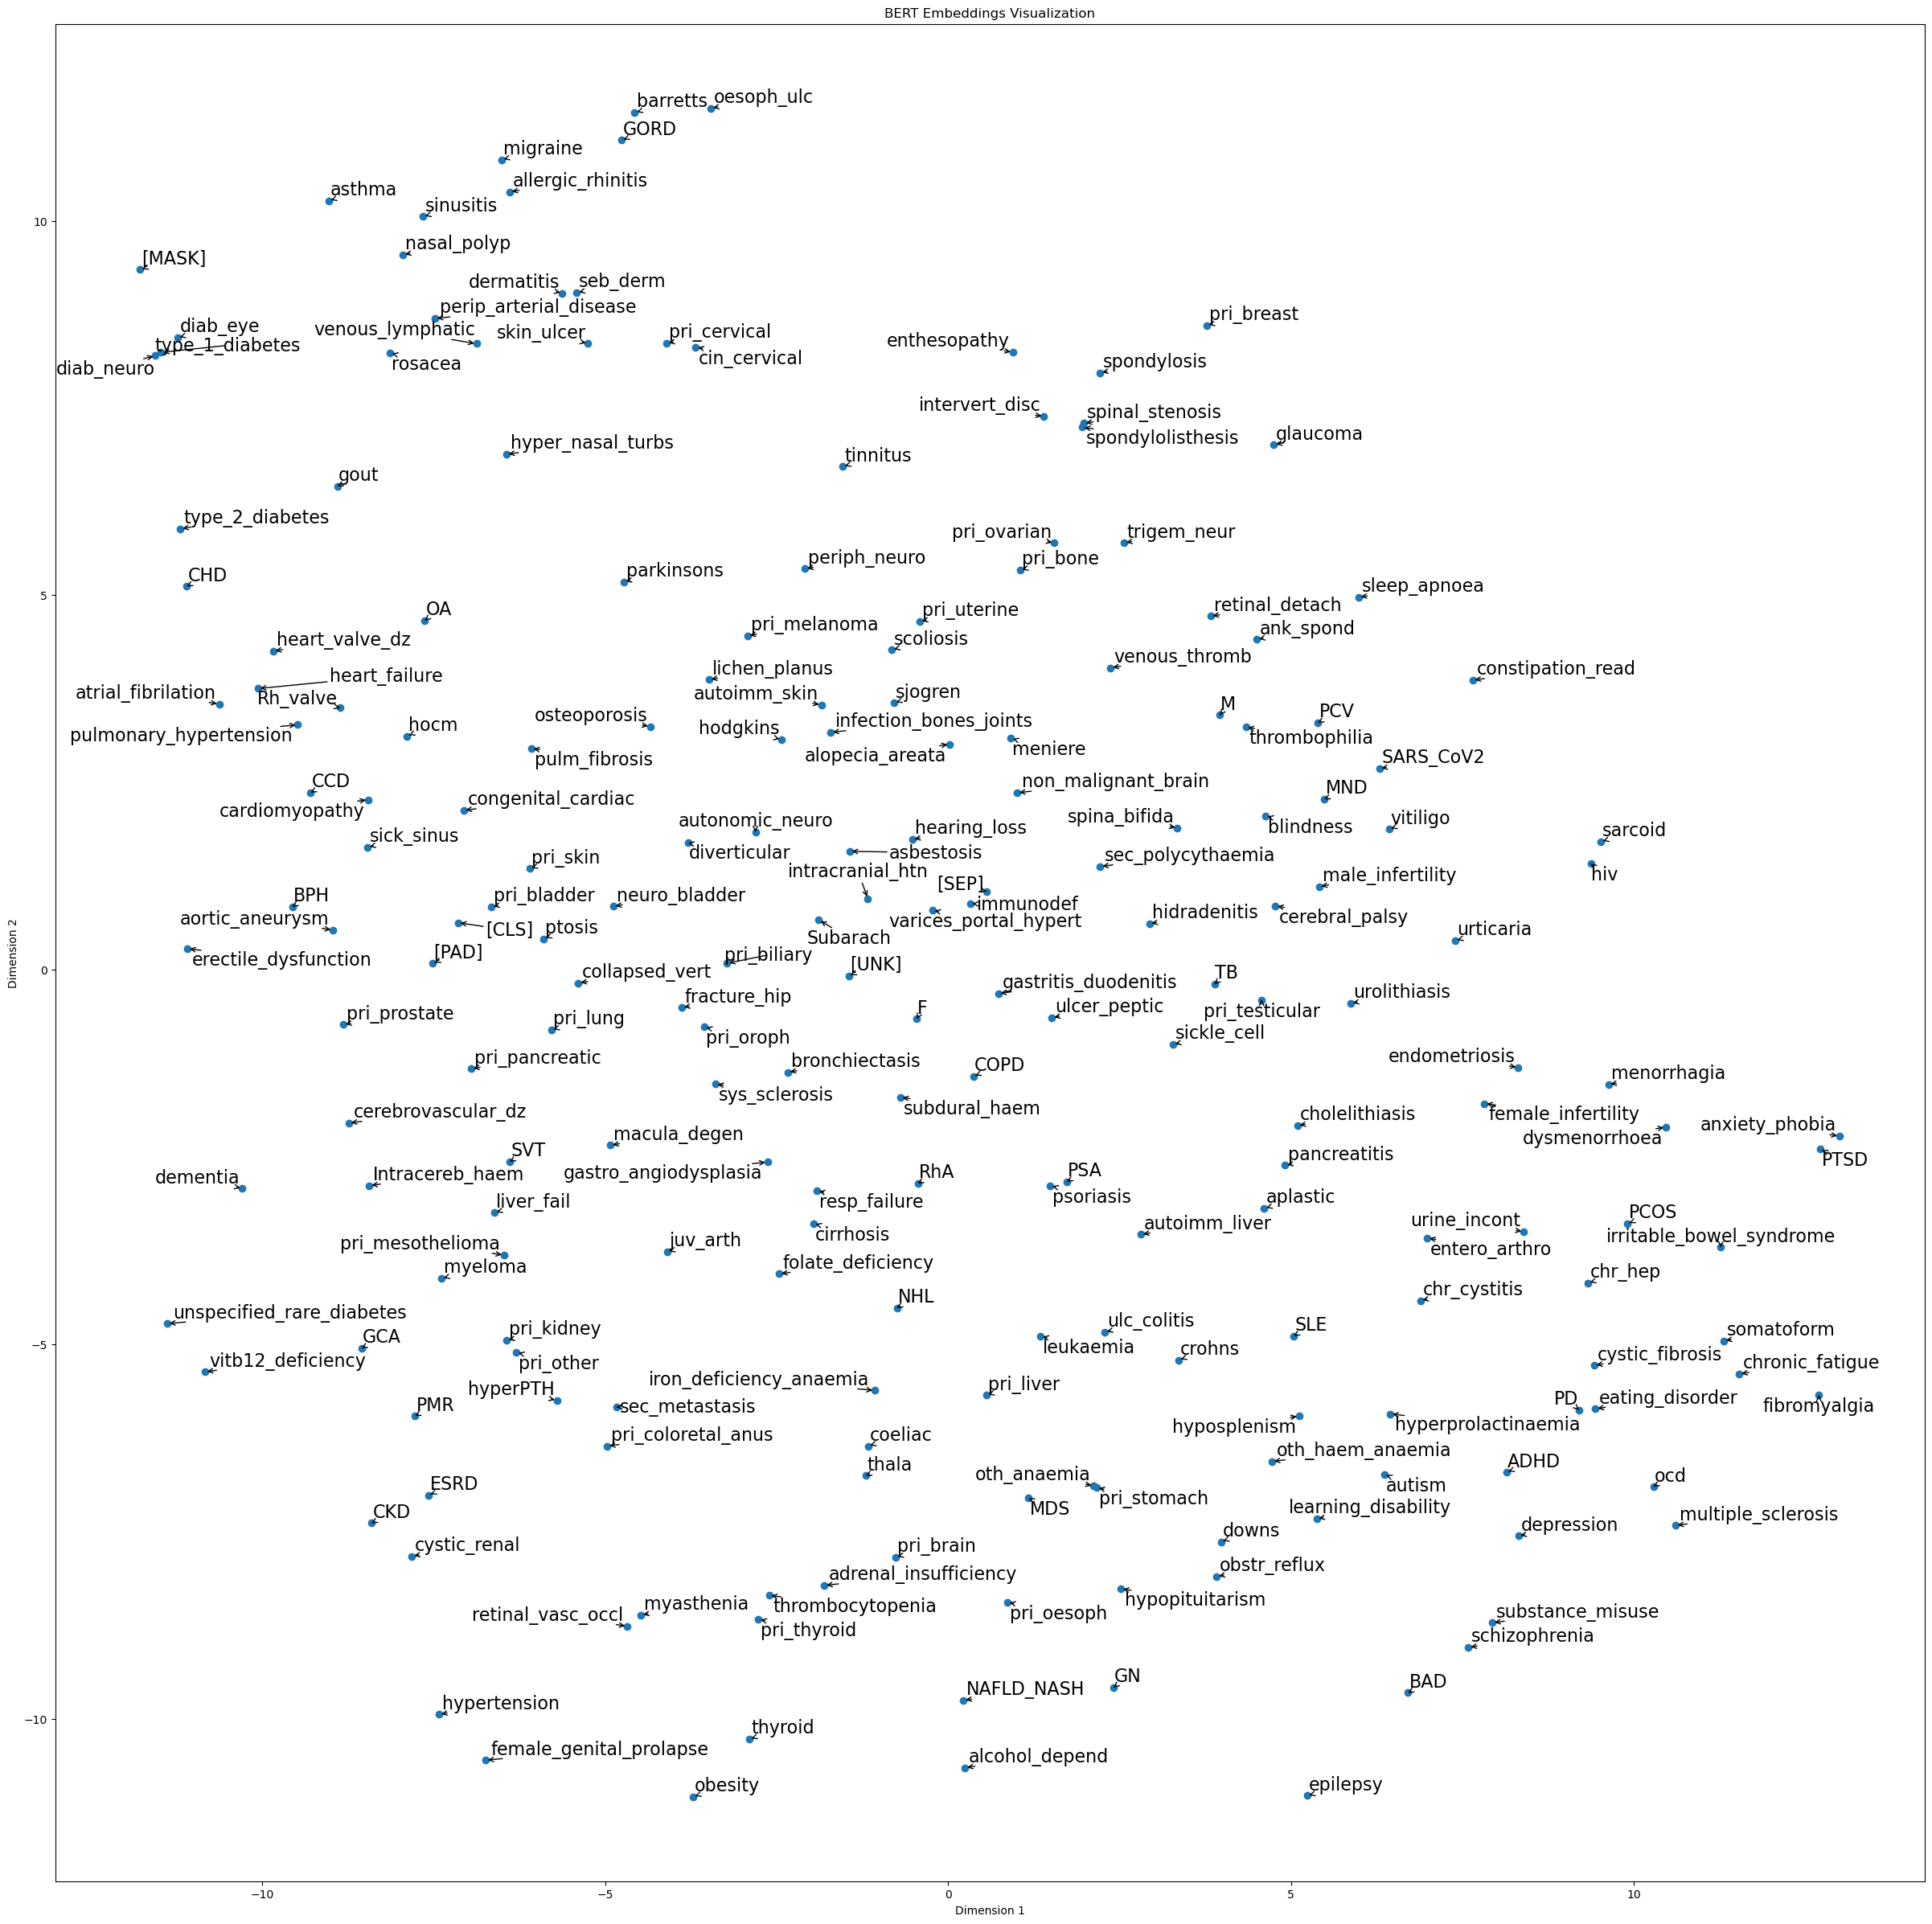

In [47]:

final_outputs = tf.concat(outputs_list, axis=0)
first_token_embeddings=final_outputs[:,0,:]
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(first_token_embeddings)
# Plot the t-SNE visualization
plt.figure(figsize=(30, 30))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title("BERT Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
# Add token names to the plot
texts = []
for i, token in enumerate(custom_vocab):
    texts.append(plt.text(embeddings_tsne[i, 0], embeddings_tsne[i, 1], token,fontsize=16))

# Adjust token labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
plt.savefig(os.path.join(main_directory,"embedding_visualization.png")) 
plt.show()

## sample Test

In [ ]:
query = "[CLS] OA [SEP] OA [SEP] OA [SEP] skin_ulcer [SEP] [MASK] [SEP] OA [SEP] OA [SEP] pri_skin [SEP]"
age_test=[53, 53, 53, 56, 56, 57, 57, 60, 60, 63, 63, 69, 69, 69, 69, 71, 71]
sex_test=[0]
input_ids,attention_mask,segment_ids,age_feature,sex_feature=preprocess_main([query],[age_test],[sex_test])
mask_loc = np.where(input_ids.numpy()[0] == 4)[0].tolist()
out = model([input_ids,attention_mask,segment_ids,age_feature,sex_feature]).numpy()
predicted_tokens = np.argmax(out[0,mask_loc,:],axis=1).tolist()
tokenizer.decode(predicted_tokens)
predicted_disease=tokenizer.decode(predicted_tokens)

# Part 4

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Dense, Embedding, Add,Concatenate,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
import os
import logging
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc
seed=10
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
main_directory=""# main directory file name

In [3]:
# Configure logging
logging.basicConfig(filename=os.path.join(main_directory,'log.log'),level=logging.INFO,format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
data=pd.read_csv(os.path.join(main_directory,'main_file.tsv'), delimiter="\t")
data=data[['patient_id','event_date','LTC_abbrev','age_at_event','sex']]
data=data.dropna().drop_duplicates()
data['Rank'] = data.groupby('patient_id')['event_date'].rank(ascending=True,method='min')
uniq_patientid=data['patient_id'].unique()

In [ ]:
def gen(x):
  if x=='F':
    return 1
  else :
    return 0
b=[]
age=[]
vocab=[]
for u in uniq_patientid:
  temp=data[data['patient_id']==u].copy()
  a=''
  c=[]
  for i in range(0,len(temp)):
   if len(temp)>7:
    if temp.iloc[i,2] not in vocab:
     vocab.append(temp.iloc[i,2])
    if len(a)==0:
     a='[CLS] '+temp.iloc[i,2]
     c.append(temp.iloc[i,3])
     c.append(temp.iloc[i,3])
    elif temp.iloc[i,1]!= temp.iloc[i-1,1]:
     a=a+' [SEP] '+temp.iloc[i,2]
     c.append(temp.iloc[i-1,3])
     c.append(temp.iloc[i,3])
    else :
      a=a+' '+ temp.iloc[i,2]
      c.append(temp.iloc[i,3])
  if len(a)>0:
   b.append(a + ' [SEP]'+' '+temp.iloc[i,4]+' [SEP]')
   c.append(temp.iloc[i,3])
   age.append(c)

## saving vocabulary

In [ ]:
# Add special tokens if desired
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]','[MASK]','M','F']
custom_vocab = special_tokens + vocab
i=0
# Save the custom vocabulary as vocab.txt
with open(os.path.join(main_directory,"vocab.txt"), 'w', encoding='utf-8') as f:
    for term in custom_vocab:
        if i<len(custom_vocab)-1:
         f.write(term + '\n')
        else:
          f.write(term)  
        i=i+1     

## loading tokenizer

In [94]:
# Path to your custom vocabulary file (vocab.txt)
vocab_file = os.path.join(main_directory,"vocab.txt")

# Create a new tokenizer instance
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)
def my_tokenization(text):
    # Implement your custom tokenization logic here
    # Return a list of tokens

    # For example, split the text by spaces
    tokens = text.split()

    return tokens

# Set the tokenizer's tokenization function to your custom function
tokenizer.tokenize = my_tokenization

In [7]:
def preprocess(combined_sentence):
 tokens = tokenizer.tokenize(combined_sentence)
 segment_ids = []
 current_segment_id = 0

 for token in tokens:
    segment_ids.append(current_segment_id)
    if token == '[SEP]':
      #if current_segment_id==1:
        #current_segment_id=0
      #else:
        #current_segment_id=1
        current_segment_id += 1
 token_ids = tokenizer.convert_tokens_to_ids(tokens)
 attention_mask = [1] * len(token_ids)
 return tokens,segment_ids,token_ids,attention_mask
def preprocess_main(h,age):
  tokens_array=[]
  segment_ids_array=[]
  token_ids_array=[]
  attention_mask_array=[]
  for st in h:
   v1,v2,v3,v4=preprocess(st)
   tokens_array.append(v1)
   segment_ids_array.append(v2)
   token_ids_array.append(v3)
   attention_mask_array.append(v4)

  max_length =987# max(len(ids) for ids in token_ids_array)
  padded_token_ids = [ids + [0] * (max_length - len(ids)) for ids in token_ids_array]
  padded_segment_ids = [ids + [0] * (max_length - len(ids)) for ids in segment_ids_array]
  attention_mask = [ids+ [0] * (max_length - len(ids)) for ids in attention_mask_array]
  age = [ids + [0] * (max_length - len(ids)) for ids in age]
  input_ids = tf.convert_to_tensor(padded_token_ids)
  segment_ids = tf.convert_to_tensor(padded_segment_ids)
  attention_mask = tf.convert_to_tensor(attention_mask)
  age_feature=tf.convert_to_tensor(age)
  return input_ids,attention_mask,segment_ids,age_feature,max_length


In [ ]:
input_ids,attention_mask,segment_ids,age_feature,max_length=preprocess_main(b,age) # should be array
labels=input_ids

In [42]:
diagnosis_statistics = pd.read_excel(os.path.join(main_directory,"diagnosis_statistics.xlsx"))

In [43]:
inp_ids_1 = []
lbs = []
idx = 0
max_length=len(input_ids[0])
for inp in input_ids.numpy():
    max_length=len(inp)
    actual_tokens = list(set(range(max_length)) -
                         set(np.where((inp == 2) | (inp == 3)
                            | (inp == 0)| (inp == 5)| (inp == 6))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    temp=pd.DataFrame()
    temp['token_idx']=actual_tokens
    temp['token_nbr']=inp[actual_tokens]
    temp = temp.merge(diagnosis_statistics, on='token_nbr')
    temp=temp.sort_values(by='prob_100', ascending=True)
    inp[temp.iloc[0:num_of_token_to_mask,0]]=4
    inp_ids_1.append(inp)
inp_ids_1 = tf.convert_to_tensor(inp_ids_1)    
input_ids=inp_ids_1

In [44]:
masked_indices_list = []
for i in range(input_ids.shape[0]):
    sequence_input_ids = input_ids[i]
    masked_indices = tf.where(tf.equal(sequence_input_ids, 4))
    masked_indices_list.append(masked_indices)

# Filter the labels based on masked indices for each sequence
masked_labels_list = []
for i in range(labels.shape[0]):
    masked_indices = masked_indices_list[i]
    sequence_labels = labels[i]
    masked_labels = tf.gather_nd(sequence_labels, masked_indices)
    masked_labels_list.append(masked_labels)

# Convert masked_labels_list into a tf.RaggedTensor
ragged_masked_label = tf.ragged.stack(masked_labels_list)
masked_labels=ragged_masked_labels=ragged_masked_label.to_tensor(default_value=0)

## saving all the input data

In [ ]:
np.save(os.path.join(main_directory,"input_ids.npy"), input_ids.numpy())
np.save(os.path.join(main_directory,"attention_mask.npy"), attention_mask.numpy())
np.save(os.path.join(main_directory,"segment_ids.npy"), segment_ids.numpy())
np.save(os.path.join(main_directory,"age_feature.npy"), age_feature.numpy())
np.save(os.path.join(main_directory,"masked_labels.npy"), masked_labels.numpy())
np.save(os.path.join(main_directory,"labels.npy"), labels.numpy())

In [5]:
# BERT Model Architecture
max_length=987
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense_1 = tf.keras.layers.Dense(vocab_size*4, activation="relu", name="pre_prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate
        self.dense_2 = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)
        prediction = self.dense_1(masked_inputs)
        prediction = self.dropout(prediction)  # Apply dropout to the dense layer output
        prediction = self.dense_2(prediction)
        return prediction
def build_bert_model(max_seq_length, vocab_size, hidden_size, num_attention_heads, num_transformer_layers, 
                     num_age_embeddings,num_segment_embedings):
    input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    age_feature = Input(shape=(max_seq_length,), dtype=tf.int32, name="age_feature")
    attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="attention_mask")
    token_type_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="token_type_ids")

    #embedding

    age_embedding = Embedding(input_dim=num_age_embeddings, output_dim=hidden_size,trainable=True,name='age_embedding')(age_feature)
    segment_embeddings=Embedding(input_dim=num_segment_embedings, output_dim=hidden_size,trainable=True,name='segment_embedding')(token_type_ids)

    #final addition of embeddings
    embeddings = Add(name='add_layer')([age_embedding, PositionalEmbedding(vocab_size, hidden_size)
                                        (input_ids),segment_embeddings])
    
    encoder_output = embeddings
    attention_mask=tf.expand_dims(attention_mask, axis=-1)
    for _ in range(num_transformer_layers):
        encoder_output = TransformerEncoderBlock(hidden_size, num_attention_heads)(encoder_output,attention_mask) 
      # Gender embedding is not trainable
           
    masked_lm = MaskedLanguageModel(vocab_size, masked_value=4, name="masked_lm")(encoder_output, input_ids)

    model = Model(inputs=[input_ids, age_feature, attention_mask, token_type_ids], outputs=masked_lm)
    return model 

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)

# Example usage
max_seq_length = max_length
vocab_size = tokenizer.vocab_size
hidden_size = 288
num_attention_heads = 8
num_transformer_layers = 8
num_age_embeddings=120
num_segment_embedings=max_length
model = build_bert_model(max_seq_length, vocab_size, hidden_size, num_attention_heads, num_transformer_layers,num_age_embeddings,num_segment_embedings)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age_feature (InputLayer)    [(None, 987)]                0         []                            
                                                                                                  
 input_ids (InputLayer)      [(None, 987)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 987)]                0         []                            
 )                                                                                                
                                                                                                  
 age_embedding (Embedding)   (None, 987, 288)             34560     ['age_feature[0][0]']     

## Loading saved data

max_length=987
index with max disease predicted 122864

In [12]:
#134947 is the 80%  of the input data
input_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids.npy"))[:134947])
attention_mask=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[:134947])
segment_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[:134947])
age_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[:134947])
masked_labels=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels.npy"))[:134947])

print('training data loaded')
logging.info('training data loaded')

training data loaded


In [3]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)
def custom_loss(y_true, y_pred):
    # Create a mask to ignore padded values in y_true
    mask = tf.not_equal(y_true, 0)

    # Apply the mask to y_true
    y_true_masked = tf.boolean_mask(y_true, mask)
   
    # Compute the sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred, from_logits=False)

    return loss
max_length=987
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense_1 = tf.keras.layers.Dense(vocab_size*4, activation="relu", name="pre_prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate
        self.dense_2 = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)
        prediction = self.dense_1(masked_inputs)
        prediction = self.dropout(prediction)  # Apply dropout to the dense layer output
        prediction = self.dense_2(prediction)
        return prediction  
max_seq_length=987    
custom_objects = {
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerEncoderBlock': TransformerEncoderBlock,
    'custom_loss':custom_loss,
    'MaskedLanguageModel':MaskedLanguageModel
}
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Custom function to run after each epoch
        # Replace this with your custom logic
        self.custom_function(epoch, logs)

    def custom_function(self,epoch, logs):
        # Add your custom logic here
        model.save(os.path.join(main_directory,"model","model.h5"))
        print(f'\nModel saved for epoch {epoch}')
        if logs is not None:
            loss = logs.get('loss')
            if loss is not None:
                print(f'Epoch {epoch} - Loss: {loss:.4f}\n')  # Add \n for a new line
                logging.info(f'Epoch {epoch} - Loss: {loss:.4f}')
 
custom_callback = CustomCallback()        

In [4]:
# loading the model
model = tf.keras.models.load_model(os.path.join(main_directory,"model_2","model.h5"), custom_objects=custom_objects)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age_feature (InputLayer)    [(None, 987)]                0         []                            
                                                                                                  
 input_ids (InputLayer)      [(None, 987)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 987)]                0         []                            
 )                                                                                                
                                                                                                  
 age_embedding (Embedding)   (None, 987, 288)             34560     ['age_feature[0][0]']     

In [20]:
# Run the code after the model is created
loss_object = custom_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=loss_object,)
history = model.fit([input_ids, age_feature, attention_mask, segment_ids],masked_labels,
                    verbose=1,batch_size=2,epochs=3,callbacks=[custom_callback])

Epoch 1/3
5/5 [==============================] - ETA: 0s - loss: 3.5901
 Model saved for epoch 0
Epoch 0 - Loss: 3.5901

5/5 [==============================] - 14s 3s/step - loss: 3.5901
Epoch 2/3
5/5 [==============================] - ETA: 0s - loss: 3.4040
 Model saved for epoch 1
Epoch 1 - Loss: 3.4040

5/5 [==============================] - 14s 3s/step - loss: 3.4040
Epoch 3/3
5/5 [==============================] - ETA: 0s - loss: 3.3110
 Model saved for epoch 2
Epoch 2 - Loss: 3.3110

5/5 [==============================] - 15s 3s/step - loss: 3.3110


## Evaluation 

In [27]:
a=134947
input_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids.npy"))[a:])
attention_mask_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[a:])
segment_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[a:])
age_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[a:])
masked_labels_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels.npy"))[a:])
print('test data loaded')

test data loaded


In [28]:
print('processing labels for testing')
mask = tf.not_equal(masked_labels_test, 0)
y_true = tf.boolean_mask(masked_labels_test, mask)

processing labels for testing


In [29]:

batch_size = 8  # Set an appropriate batch size based on your memory constraints

# Function to iterate over batches and generate predictions
def predict_in_batches(model, data):
     predictions = []
     probabilities=[]
     i=0   
     num_samples = len(data[0])
     for start_idx in range(0, num_samples, batch_size):
         end_idx = min(start_idx + batch_size, num_samples)
         batch_input = [d[start_idx:end_idx] for d in data]
         batch_predicted_scores = model(batch_input)
         batch_y_pred = np.argmax(batch_predicted_scores, axis=1)
         predictions.extend(batch_y_pred)
         probabilities.extend(batch_predicted_scores)
         i=i+1
         print(f'batch size {i}/{math.ceil(num_samples/batch_size)} completed')  
     return predictions,probabilities

# Get predictions in batches
y_pred,probabilities = predict_in_batches(model, [input_ids_test, age_feature_test, attention_mask_test, segment_ids_test])
probab = np.vstack(probabilities)

batch size 1/13 completed
batch size 2/13 completed
batch size 3/13 completed
batch size 4/13 completed
batch size 5/13 completed
batch size 6/13 completed
batch size 7/13 completed
batch size 8/13 completed
batch size 9/13 completed
batch size 10/13 completed
batch size 11/13 completed
batch size 12/13 completed
batch size 13/13 completed


## Classification Report

In [ ]:
# Compute the final classification report
cr = classification_report(y_true, y_pred, zero_division=0)
print(cr)

## Average AUC

In [86]:
true_labels = np.array(y_true)  # True class labels
predicted_scores = np.array(probab)
# Get unique classes with at least one sample having true label
unique_classes = np.unique(true_labels)

# Calculate AUC for each class
auc_scores = []
for class_idx in unique_classes:
    true_class_labels = (true_labels == class_idx).astype(int)
    auc_scores.append(roc_auc_score(true_class_labels, predicted_scores[:, class_idx]))

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print("Average AUC:", average_auc)

Average AUC: 0.8119045653633721


## confusion matrix and plot

In [ ]:
# Compute the final confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(main_directory, 'confusion_matrix.png'))  # Save the plot as an image file
plt.show()

print('Confusion matrix saved')

 ## Embedding -visualisation 

In [5]:
# Path to your custom vocabulary file (vocab.txt)
vocab_file = os.path.join(main_directory,"vocab.txt")

# Create a new tokenizer instance
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)
def my_tokenization(text):
    # Implement your custom tokenization logic here
    # Return a list of tokens

    # For example, split the text by spaces
    tokens = text.split()

    return tokens

# Set the tokenizer's tokenization function to your custom function
tokenizer.tokenize = my_tokenization

In [8]:
# Read the text from a file
with open(os.path.join(main_directory,"vocab.txt"), 'r') as file:
    text = file.read()

# Split the text into an array of lines
lines = text.split('\n')
custom_vocab=[]
# Print the lines
for line in lines:
    custom_vocab.append(line)
input_ids,attention_mask,segment_ids,age_feature,max_length=preprocess_main(custom_vocab,np.zeros((210,1)))
zeros_column = tf.zeros((tf.shape(age_feature)[0], 1), dtype=tf.float64)

# Concatenate the original tensor and the tensor of zeros along the second dimension (axis=1)
age_feature = tf.concat([age_feature, zeros_column], axis=1)
layer_name = 'transformer_encoder_block_5'  # Replace this with the actual name of the layer you want

# Create an intermediate model that outputs activations from the desired layer
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
batch_size = 32  # You can adjust this based on your system's memory capacity and performance

# Create a TensorFlow Dataset from the inputs
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, segment_ids, age_feature))

# Batch the dataset into smaller batches
batched_dataset = dataset.batch(batch_size)

# Create an empty list to store the model outputs
outputs_list = []
# Iterate through the batches and run model inference on each batch
for batch_input_ids, batch_attention_mask, batch_segment_ids, batch_age_feature in batched_dataset:
    # Run the model on the batch
    batch_outputs = intermediate_model([batch_input_ids, batch_attention_mask, batch_segment_ids, batch_age_feature])

    # Append the batch outputs to the list
    outputs_list.append(batch_outputs)

# Concatenate the outputs from all batches


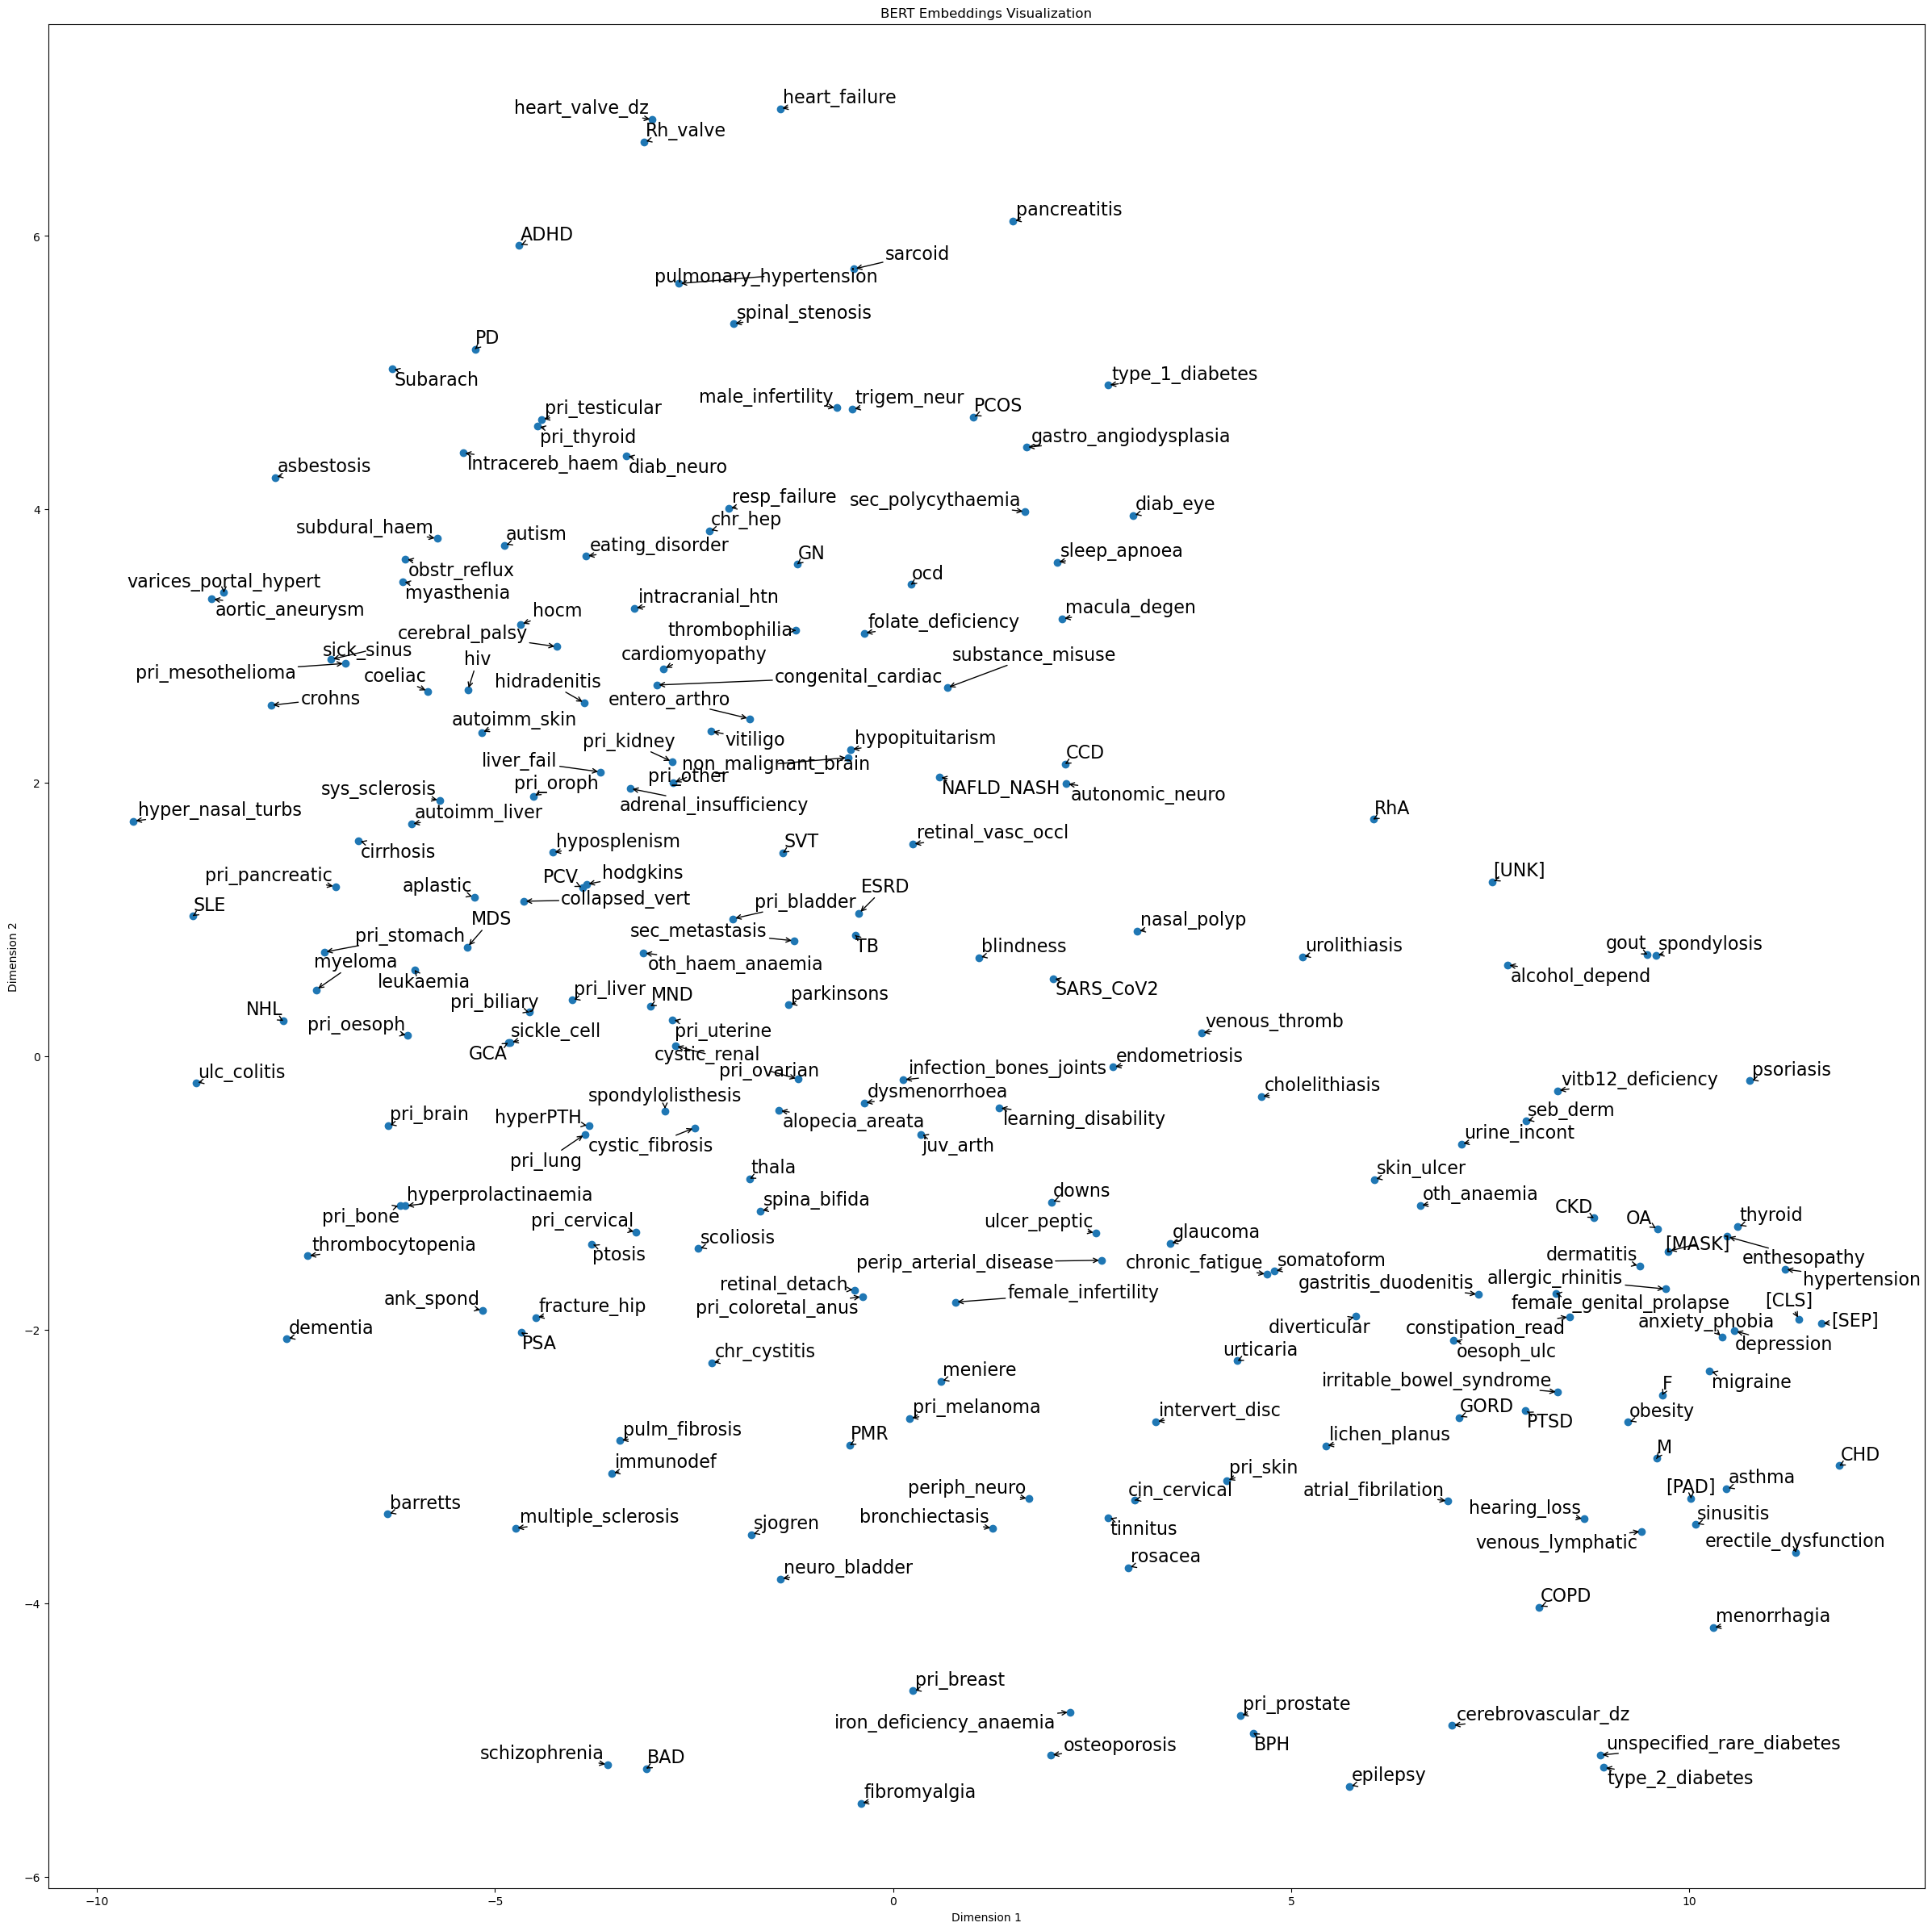

In [9]:
final_outputs = tf.concat(outputs_list, axis=0)
first_token_embeddings=final_outputs[:,0,:]
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(first_token_embeddings)
# Plot the t-SNE visualization
plt.figure(figsize=(30, 30))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title("BERT Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
# Add token names to the plot
texts = []
for i, token in enumerate(custom_vocab):
    texts.append(plt.text(embeddings_tsne[i, 0], embeddings_tsne[i, 1], token,fontsize=16))

# Adjust token labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
plt.savefig(os.path.join(main_directory, '"embedding_visualization_1.png"')) 
plt.show()

In [ ]:
# Compute the final confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(main_directory, 'confusion_matrix.png'))  # Save the plot as an image file
plt.show()

print('Confusion matrix saved')


## Sample Test 

In [48]:
query = "[CLS] OA [SEP] OA [SEP] OA [SEP] skin_ulcer [SEP] [MASK] [SEP] OA [SEP] OA [SEP] pri_skin [SEP] M [SEP]"
age_test=[53, 53, 53, 56, 56, 57, 57, 60, 60, 63, 63, 69, 69, 69, 69, 71, 71]
input_ids,attention_mask,segment_ids,age_feature,max_length=preprocess_main([query],[age_test])
out = model([input_ids,attention_mask,segment_ids,age_feature]).numpy()
predicted_tokens = np.argmax(out,axis=1).tolist()
tokenizer.decode(predicted_tokens)
predicted_disease=tokenizer.decode(predicted_tokens)
print(predicted_disease)

OA


# Next Diagnosis Prediction

In this method , model trained in part 3 is used to predict the next disease. The process is simple, instead of random masking , masking the second last token will perform this task. Remaining steps are all same as that of part 3.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Dense, Embedding, Add,Concatenate,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
from sklearn.metrics import roc_curve, auc #label_binarize
import logging
from sklearn.metrics import roc_auc_score, roc_curve
import os
import math
seed=10
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
main_directory="" # should be the one give in part 3

In [ ]:
# Configure logging
logging.basicConfig(filename=os.path.join(main_directory,'log_next.log'),level=logging.INFO,format='%(asctime)s - %(levelname)s - %(message)s')

## Pre-process

In [51]:
input_ids_next =input_ids=labels=tf.convert_to_tensor(np.load(os.path.join(main_directory,"labels.npy")))

In [52]:
input_ids_next=input_ids_next.numpy()
for i in range(len(input_ids)):
    row = input_ids[i]
    
    # Find indices of non-padding elements (assuming padding is represented by 0)
    non_padding_indices = np.nonzero(row)
    
    # Check if there are at least 2 non-padding elements
    if len(non_padding_indices[0]) >= 2:
        # Get the index of the second-to-last non-padding element
        second_to_last_index = non_padding_indices[0][-2]
        
        # Assign a value of 4 to the second-to-last non-padding element
        input_ids_next[i, second_to_last_index] = 4


In [55]:
masked_indices_list = []
for i in range(input_ids_next.shape[0]):
    sequence_input_ids = input_ids_next[i]
    masked_indices = tf.where(tf.equal(sequence_input_ids, 4))
    masked_indices_list.append(masked_indices)

# Filter the labels based on masked indices for each sequence
masked_labels_list = []
for i in range(labels.shape[0]):
    masked_indices = masked_indices_list[i]
    sequence_labels = labels[i]
    masked_labels = tf.gather_nd(sequence_labels, masked_indices)
    masked_labels_list.append(masked_labels)

# Convert masked_labels_list into a tf.RaggedTensor
ragged_masked_label = tf.ragged.stack(masked_labels_list)
masked_labels_next=ragged_masked_label.to_tensor(default_value=0)
  

## saving the modified input_id and masked label 

In [56]:
np.save(os.path.join(main_directory,"input_ids_next.npy"), input_ids_next)
np.save(os.path.join(main_directory,"masked_labels_next.npy"), masked_labels_next.numpy())

## loading Data

In [60]:
a=134947
input_ids_next=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids_next.npy"))[:a])
attention_mask=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[:a])
segment_ids=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[:a])
age_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[:a])
sex_feature=tf.convert_to_tensor(np.load(os.path.join(main_directory,"sex_feature.npy"))[:a])
masked_labels_next=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels_next.npy"))[:a])

## Training

In [3]:
class MaskedLanguageModel(tf.keras.layers.Layer):
    def __init__(self, vocab_size, masked_value=4, name="masked_lm"):
        super(MaskedLanguageModel, self).__init__(name=name)
        self.vocab_size = vocab_size
        self.masked_value = masked_value
        self.dense_1 = tf.keras.layers.Dense(vocab_size*4, activation="relu", name="pre_prediction")
        self.dropout = Dropout(0.1)  # Add dropout layer with 10% dropout rate
        self.dense_2 = tf.keras.layers.Dense(vocab_size, activation="softmax", name="prediction")

    def call(self, inputs, input_ids):
        # Mask the tokens with the masked_value from input_ids before passing them through the prediction head
        masked_indices = tf.where(tf.equal(input_ids, self.masked_value))
        masked_inputs = tf.gather_nd(inputs, masked_indices)
        prediction = self.dense_1(masked_inputs)
        prediction = self.dropout(prediction)  # Apply dropout to the dense layer output
        prediction = self.dense_2(prediction)
        return prediction
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, hidden_size):
    super().__init__(name='PositionalEmbedding/word')
    self.d_model = hidden_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, hidden_size, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=max_seq_length, depth=hidden_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# Transformer Encoder Block
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_attention_heads):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_attention_heads, key_dim=hidden_size//num_attention_heads
        )
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_size*4, activation="relu"),
            tf.keras.layers.Dense(hidden_size)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs,attention_mask):
        attention_output = self.attention(inputs, inputs, attention_mask=attention_mask)  # Pass attention_mask
        attention_output = self.layer_norm1(inputs + attention_output)
        feed_forward_output = self.feed_forward(attention_output)
        return self.layer_norm2(attention_output + feed_forward_output)
def custom_loss(y_true, y_pred):
    # Create a mask to ignore padded values in y_true
    mask = tf.not_equal(y_true, 0)

    # Apply the mask to y_true
    y_true_masked = tf.boolean_mask(y_true, mask)
    # Compute the sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred, from_logits=False)

    return loss    
max_seq_length=985    
custom_objects = {
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerEncoderBlock': TransformerEncoderBlock,
    'custom_loss':custom_loss,
    'MaskedLanguageModel':MaskedLanguageModel
}
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Custom function to run after each epoch
        # Replace this with your custom logic
        self.custom_function(epoch, logs)

    def custom_function(self,epoch, logs):
        # Add your custom logic here
        model.save(os.path.join(main_directory,"model_next","model_next.h5"))
        print(f'\nModel saved for epoch {epoch}')
        if logs is not None:
            loss = logs.get('loss')
            if loss is not None:
                print(f'Epoch {epoch} - Loss: {loss:.4f}\n')  # Add \n for a new line
                logging.info(f'Epoch {epoch} - Loss: {loss:.4f}')
 
custom_callback = CustomCallback()            

In [59]:
# Load the model with custom objects
model = tf.keras.models.load_model(os.path.join(main_directory,"model","model.h5"), custom_objects=custom_objects)# loading trained model

In [ ]:
history = model.fit([input_ids_next, age_feature, attention_mask, segment_ids,sex_feature],masked_labels_next,
                    verbose=1,batch_size=2,epochs=1,callbacks=[custom_callback],workers=3)

## Evaluation

In [13]:
model = tf.keras.models.load_model(os.path.join(main_directory,"model_next","model_next.h5"), custom_objects=custom_objects)# loading trained model

In [14]:
a=134947
b=a+100*1
input_ids_test_next=tf.convert_to_tensor(np.load(os.path.join(main_directory,"input_ids_next.npy"))[a:b])
attention_mask_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"attention_mask.npy"))[a:b])
segment_ids_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"segment_ids.npy"))[a:b])
age_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"age_feature.npy"))[a:b])
sex_feature_test=tf.convert_to_tensor(np.load(os.path.join(main_directory,"sex_feature.npy"))[a:b])
masked_labels_test_next=tf.convert_to_tensor(np.load(os.path.join(main_directory,"masked_labels_next.npy"))[a:b])
print('test data loaded')

test data loaded


In [15]:
print('processing labels for testing')
mask = tf.not_equal(masked_labels_test_next, 0)
y_true = tf.boolean_mask(masked_labels_test_next, mask)

processing labels for testing


In [17]:
batch_size = 8  # Set an appropriate batch size based on your memory constraints

# Function to iterate over batches and generate predictions
def predict_in_batches(model, data):
     predictions = []
     probabilities=[]
     i=0   
     num_samples = len(data[0])
     for start_idx in range(0, num_samples, batch_size):
         end_idx = min(start_idx + batch_size, num_samples)
         batch_input = [d[start_idx:end_idx] for d in data]
         batch_predicted_scores = model(batch_input)
         batch_y_pred = np.argmax(batch_predicted_scores, axis=1)
         predictions.extend(batch_y_pred)
         probabilities.extend(batch_predicted_scores)
         i=i+1
         print(f'batch size {i}/{math.ceil(num_samples/batch_size)} completed')  
     return predictions,probabilities

# Get predictions in batches
y_pred,probabilities = predict_in_batches(model, [input_ids_test_next, age_feature_test, attention_mask_test, segment_ids_test,sex_feature_test])
probab = np.vstack(probabilities)


batch size 1/13 completed
batch size 2/13 completed
batch size 3/13 completed
batch size 4/13 completed
batch size 5/13 completed
batch size 6/13 completed
batch size 7/13 completed
batch size 8/13 completed
batch size 9/13 completed
batch size 10/13 completed
batch size 11/13 completed
batch size 12/13 completed
batch size 13/13 completed


In [ ]:
cr = classification_report(y_true, y_pred, zero_division=0)
print(cr)

## Average AUC

In [20]:

true_labels = np.array(y_true)  # True class labels
predicted_scores = np.array(probab)
# Get unique classes with at least one sample having true label
unique_classes = np.unique(true_labels)

# Calculate AUC for each class
auc_scores = []
for class_idx in unique_classes:
    true_class_labels = (true_labels == class_idx).astype(int)
    auc_scores.append(roc_auc_score(true_class_labels, predicted_scores[:, class_idx]))

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print("Average AUC:", average_auc)

Average AUC: 0.7946359997903943


## confusion matrix and plot

In [ ]:
# Compute the final confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(main_directory, 'confusion_matrix_next.png'))  # Save the plot as an image file
plt.show()

print('Confusion matrix saved')